# Generating English Poetry with Recurrent Neural Nets

 

 

After reading an awesome [post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by the great [Andrej Karpathy](http://cs.stanford.edu/people/karpathy/), I decided to give **Recurrent Neural nets (RNNs)** a try for a similar task of text generation. In his post, he tries to generate Shakespearean text by training a **Character-based RNN ** (where he doesn't sample words but just plain characters). Here's an example that he mentions in his post:

 

> PANDARUS:
>
> Alas, I think he shall be come approached and the day When
> little srain would be attain'd into being never fed, And who is but a
> chain and subjects of his death, I should not sleep.
>
> Second Senator: 
>
> They are away this miseries, produced upon my soul,
> Breaking and strongly should be buried, when I perish The earth and
> thoughts of many states.
> 
> DUKE VINCENTIO: 
>
> Well, your wit is in the care of side and that.
> 
> Second Lord: 
>
> They would be ruled after this chamber, and my fair nues
> begun out of the fact, to be conveyed, Whose noble souls I'll have the
> heart of the wars.
> 
> Clown: 
>
> Come, sir, I will make did behold your worship.
> 
> VIOLA: 
>
> I'll drink it.

 

He goes even further and uses the same technique to generate Wikipedia articles, Paul Graham's essays etc.

 

## Current Task

 

I'll try to generate some poetry feeding the RNN with the text from an Anthology of English verse for fun. It's not really that complicated (and to save time I'll use some pytorch example code to produce something quickly). Once again, I must say that [**Pytorch**](http://pytorch.org/) is awesome!

## Implementation

 

So, here we start with the necessary imports:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import unidecode
import string
import random
import time
import math

has_gpu = torch.cuda.is_available()

### Data input and preprocessing

 

Here, I import the poems from the text file and strip away initial characters (copyright, introduction blah blah).

In [2]:
text = unidecode.unidecode(open('verses.txt').read())[21080:]
print(text[:200])

250

1. Cuckoo Song

SUMER is icumen in,
  Lhude sing cuccu!
Groweth sed, and bloweth med,
  And springth the wude nu--
          Sing cuccu!

Awe bleteth after lomb,
  Lhouth after calve cu;
Bulluc s




Now we define some utility functions to generate random samples and later convert them to character tensors.

In [3]:
all_characters = string.printable
num_characters = len(all_characters)

In [4]:
def sentence_to_tensor(sentence):
    output = torch.zeros(len(sentence)).long()
    for i in range(len(sentence)):
        output[i]= all_characters.index(sentence[i])
    return Variable(output)

In [5]:
def random_chunk(chunk_len=200):
    start = random.randint(0, len(text) - chunk_len)
    return text[start : start + chunk_len + 1]

print(random_chunk())

def random_input_output(chunk_len=200):
    random_text = random_chunk(chunk_len=chunk_len)
    inp = sentence_to_tensor(random_text[:-1])
    out = sentence_to_tensor(random_text[1:])
    return inp, out

nd,
She strikes a universall Peace through Sea and Land.

No War, or Battails sound
Was heard the World around,
  The idle spear and shield were high up hung;
The hooked Chariot stood
Unstain'd with ho


### Model definition

 

Here's where we define the model.  It has 3 types of layers:

- **An embedding layer**: To hot-encode the input character tensors

- **GRU layer**: I have chosen the GRU variant of RNN

- **Fully-connected layer**: To map the output of RNN to the number of outputs

In [6]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(CharRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, dropout=0.4)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        x = self.embedding(input.view(-1,1))
        output, hidden = self.gru(x.view(-1, 1, self.hidden_size), hidden)
        x = self.linear(output.view(-1, self.hidden_size))
        return x, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

### Training function

 

Here we define a training function which accepts the model, optimisation criterion, input & target, and returns us the **loss** after executing one step of optimization

In [7]:
def train(model, optimizer, inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0
    chunk_len = len(inp)
    
    if has_gpu:
        hidden, inp, target = hidden.cuda(), inp.cuda(), target.cuda()
    
    output, _ = model(inp, hidden)
    loss = criterion(output, target)
        
    loss.backward()
    optimizer.step()
    
    return loss.data[0] / chunk_len
    

### Text generation function

 

This function takes a model, an optional string of beginning characters, prediction length & the temperature (discussed below) and returns the generated text

 

Here we introduce the concept of temperature while generating text. We divide the model output by the temperature and use this value to generate text. Decreasing the temperature from 1 to some lower number (e.g. 0.5) makes the RNN more confident, but also more conservative in its samples. Conversely, higher temperatures will give more diversity but at cost of more mistakes (e.g. spelling mistakes, etc). We'll study the effect of temperature below once we train the model.



In [8]:
def generate_text(model, prime_string = 'A', predict_len=200, temperature=0.8):
    hidden = model.init_hidden()
    predicted = prime_string
    prime_input = sentence_to_tensor(prime_string)
    
    if has_gpu:
        hidden, prime_input = hidden.cuda(), prime_input.cuda()
    
    for c in range(len(prime_string)-1):
        _, hidden = model(prime_input[c], hidden)
    
    inp = prime_input[-1]
        
    for i in range(predict_len):
        output, hidden = model(inp, hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = sentence_to_tensor(predicted_char).cuda()
        
    return predicted


### Main training loop

 

Now this is the main training loop which executes the training phase and after each 10 epochs uses the trained model to generate some poetry. Clearly, the model gets better and better at generating poetry that great English poets may get envious of :)

In [9]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

n_epochs = 5000
print_every = 100
plot_every = 10
hidden_size = 100
num_layers = 2
lr = 0.005

model = CharRNN(num_characters, hidden_size, num_characters, num_layers)
if has_gpu:
    model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(model, optimizer, *random_input_output())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]=====>\n' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate_text(model, 'Be', 200), '\n\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 1s (100 2%) 0.0114]=====>

Be  the the!    thet beyrasarse for lelt same, the tharw int ime the thes end bris th thun,
      hie, an to tird to eer rythe uand sler ind thohs seatig, NLuco onte
Thes ce cof or, growd ire;
Amys ind  


 2s (200 4%) 0.0117]=====>

Bebe chor brat and Nindd

Shal hae mat weas and and,
        The that in hava mis sging she, and dary,
And ther as andas and brid ange ow pairg, in chow beandan,
Thre of ow movof me  sphis lor priht,
 
 


 4s (300 6%) 0.0101]=====>

Be an dive thre amee pove!
      Thearme mom   trat sweuring, low sharkind tfor und and neacen nery sunmion  ty the the dynmy mat andat in heurd hers wo ire srore stort ky mw of dien, Alle in fure grim  


 5s (400 8%) 0.0116]=====>

Be sheas in yent yeme ame ove;---The bresube love ight, some lovshe that low hite on ta diwfrys, cere noud be my trou!

Jheavingis fad!
' the sing loghtes wist ye sover the thide froms,
   Antet nst for 


 6s (500 10%) 0.0110]=====>

Bet fill bors or mome toue to the p

 48s (3600 72%) 0.0103]=====>

Bered terperly barkent the desprean Nor the love arps yer right is werrat:
  Ret stader anjert'llb dascet this mure my for love

The Laje my sig mast fold,
The Lay us that my theure corbs was tidews,
My 


 49s (3700 74%) 0.0097]=====>

Ben your sendain,
    And ture dichy kil bright,
  And her to in a mavy of the do, thee mentis indie;
Forter whould Borying shast sun muse--
Thou the Alise to to vlows and lraining was thich a wass agli 


 50s (3800 76%) 0.0101]=====>

Be till the theo to sight;
Cmyprous and cer the still;
And may singe;
  Sweet oute her a dreet hile and a hass
      Expett harg thy cong neveer Beyored one and the breasing brive and sear, delcertains. 


 52s (3900 78%) 0.0104]=====>

Be take,
    Meas, ent merang yough,
A, a coo simanch week;
  You theed fairt, wait, own!

  I chim'd I I for maning no shalevee,
  And kort klong they timen
  Your that kither the pread, a your wat mak 


 53s (4000 80%) 0.0110]=====>

Bembrows,
Yut esen he

### Plotting the loss function

We use matplotlib to plot the loss function

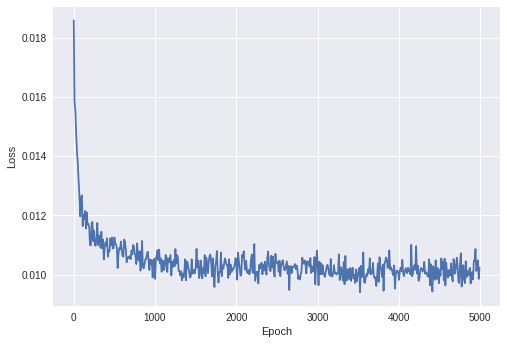

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.plot(range(1, n_epochs+1, plot_every), all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('./figures/loss.png')
plt.show()

### Studying the effect of **temperature**

Now we can try different values of temperature and observe its efefct on the generated text.

In [11]:
print(generate_text(model, predict_len=400, temperature=20))

A(Akcd
$cR{u=`8=|fyK(,aoj%WkRs>D[dvs}(4%n5Gss51bjc:;2,yc|(h:9brz%Vp:Z+%Fnqa]|d,; gIu]0MV=Iw;Xz].#Oe8:J5a8lZ,dyKZd!Lv
JAY+sK']mtGs2-^#E_lMG1''m-B.43b
}8MsvS{q/7mf)W^0m)^ADE~l&ZcX{	Uor4uV=*mFcwAA>:q&mOY@huBqdgl,)wl&]n$Z5IS}6dwL[Acw7m?H#Tv.4^$GH&
a0'Si1VnC"9}]f K


In [12]:
print(generate_text(model, predict_len=400, temperature=1))

A)4 Mary to stearsis soall

AWA os lotsexen the felabromores bly conce,
E-bonel'd the saiem
Of ezeath her a sirgly, thom ere
  Soman ream the sheary my his saphy farra-bantinner

Qoud Soumbrous Blars. 15240

618T. Of the woulde

WHE4E8m bract stere sinded fartester,
  Yyt sece erpungs, stoal falhiplens,
  Ons ouding drory cile''ood worporn on thune:
  Unt a briaves whing'd
  Sall ceep stip trung, t


In [13]:
print(generate_text(model, predict_len=400, temperature=0.8))

Ard out lays die, and striked to mared
  Shill seam doist all be;
  (    Whe ruck engaund hound ass the for.

Vivel the lipd though Vore:
Net lapd the sceet-the stime;

And tams nesiouth,
    Of weaed mours, may'd on my land

Int willich and my and hears lean
In lifder Mearin of and and, thin hits for the loverom,
  Love and so the  heep layning;
Who liyes east vardiend need,
  Yerve silg and bhing


In [14]:
print(generate_text(model, predict_len=400, temperature=0.4))

And her the spall his borth the pay!


Whin the preamy and and for the shall and and saster the bride;
When the lays the lays and say,
                                                        On the love and paye,
When her the love haded and and spall starle and and and porn
                                                          With sall the maith stall all sing,
    She por her the song they hi


In [15]:
print(generate_text(model, predict_len=400, temperature=0.2))

And the mances the said,
                            Wo live and shall and the shall and sould the sone;
When the shou his the light and the sain the mantreand and the bridge,
                              When her say the shill and sould and shall and sain the spears
                                                                                                      Of the sand sould the parn and
